# Anomaly detection on traceroute measurements
The goal for this Jupyter Notebook is to gain a better understanding off how the traceroute measurement data looks and in what way we can detect anomalies in the data.

The data selected is from an anchoring measurement towards an anchor located in San Fransisco, around the time of an internet outage from Fastly [1].
According to the article the outage should be around 11:00 UTC on june 8th. 

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from sklearn.ensemble import IsolationForest
from luminol.anomaly_detector import AnomalyDetector

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload

In [25]:
df = pd.read_feather("measurement_data/traceroute_1.feather")
df = df.dropna()
df

,index,created,probe_id,source_address,end_time,paris_id,total_hops,last_median_rtt,destination_ip_responded,last_hop_responded,is_success,last_hop_errors
0,0,2021-06-07 00:08:58+00:00,6086,80.241.3.66,2021-06-07 00:10:45+00:00,13,23,245.963,True,True,True,[]
1,1,2021-06-07 00:08:57+00:00,6111,159.253.17.197,2021-06-07 00:10:09+00:00,12,16,176.827,True,True,True,[]
2,2,2021-06-07 00:08:57+00:00,6245,5.20.2.255,2021-06-07 00:10:32+00:00,5,26,171.303,True,True,True,[]
3,3,2021-06-07 00:08:57+00:00,6246,37.44.1.36,2021-06-07 00:10:25+00:00,15,19,158.977,True,True,True,[]
4,4,2021-06-07 00:08:58+00:00,6250,212.227.112.66,2021-06-07 00:10:35+00:00,14,20,159.602,True,True,True,[]
...,...,...,...,...,...,...,...,...,...,...,...,...
203796,203796,2021-06-09 23:54:13+00:00,7006,5.145.135.67,2021-06-09 23:55:37+00:00,12,19,148.533,True,True,True,[]
203797,203797,2021-06-09 23:54:10+00:00,7007,63.222.188.9,2021-06-09 23:55:44+00:00,5,19,194.523,True,True,True,[]
203798,203798,2021-06-09 23:54:03+00:00,7008,193.46.104.17,2021-06-09 23:55:54+00:00,12,30,158.580,True,True,True,[]
203799,203799,2021-06-09 23:54:13+00:00,7009,45.94.14.204,2021-06-09 23:55:18+00:00,1,16,214.279,True,True,True,[]


In [3]:
def calc_score(median, hops):
    if hops is None:
        return 0
    return abs(hops-median)

def normalize(min_score, max_score, score):
    if max_score-min_score == 0:
        return 0
    return (score-min_score) / (max_score-min_score)

def get_country_code(probe_id):
    response = requests.get(f"https://atlas.ripe.net/api/v2/probes/{probe_id}").json()
    return response['country_code']

In [26]:
"""
x- as de tijd
y- as de unieke probes
de kleur van licht naar donker. Licht is als er niets aan de hand is en donker als het een aantal standaard afwijkingen afwijkt
 """

unique_probes = df['probe_id'].unique()

for i, probe_id in enumerate(unique_probes):
    hops_series_probe = df[df['probe_id'] == probe_id]['total_hops']
    median = hops_series_probe.median()
    scores = hops_series_probe.apply(lambda total_hops: calc_score(median, total_hops))
    score_max = scores.max()
    score_min = scores.min()
    normalized_scores = scores.apply(lambda score: normalize(score_min, score_max, score))
    df.loc[df['probe_id'] == probe_id, 'median_probe_hops'] = median
    df.loc[df['probe_id'] == probe_id, 'not_normalized_score'] = scores
    df.loc[df['probe_id'] == probe_id, 'normalized_score'] = normalized_scores
    df.loc[df['probe_id'] == probe_id, 'country_code'] = get_country_code(probe_id)
    
df

,index,created,probe_id,source_address,end_time,paris_id,total_hops,last_median_rtt,destination_ip_responded,last_hop_responded,is_success,last_hop_errors,median_probe_hops,not_normalized_score,normalized_score,country_code
0,0,2021-06-07 00:08:58+00:00,6086,80.241.3.66,2021-06-07 00:10:45+00:00,13,23,245.963,True,True,True,[],23.0,0.0,0.000,KZ
1,1,2021-06-07 00:08:57+00:00,6111,159.253.17.197,2021-06-07 00:10:09+00:00,12,16,176.827,True,True,True,[],15.0,1.0,1.000,EE
2,2,2021-06-07 00:08:57+00:00,6245,5.20.2.255,2021-06-07 00:10:32+00:00,5,26,171.303,True,True,True,[],26.0,0.0,0.000,LT
3,3,2021-06-07 00:08:57+00:00,6246,37.44.1.36,2021-06-07 00:10:25+00:00,15,19,158.977,True,True,True,[],19.0,0.0,0.000,DE
4,4,2021-06-07 00:08:58+00:00,6250,212.227.112.66,2021-06-07 00:10:35+00:00,14,20,159.602,True,True,True,[],20.0,0.0,0.000,DE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203796,203796,2021-06-09 23:54:13+00:00,7006,5.145.135.67,2021-06-09 23:55:37+00:00,12,19,148.533,True,True,True,[],19.0,0.0,0.000,DE
203797,203797,2021-06-09 23:54:10+00:00,7007,63.222.188.9,2021-06-09 23:55:44+00:00,5,19,194.523,True,True,True,[],19.0,0.0,0.000,MY
203798,203798,2021-06-09 23:54:03+00:00,7008,193.46.104.17,2021-06-09 23:55:54+00:00,12,30,158.580,True,True,True,[],29.0,1.0,0.125,AT
203799,203799,2021-06-09 23:54:13+00:00,7009,45.94.14.204,2021-06-09 23:55:18+00:00,1,16,214.279,True,True,True,[],16.0,0.0,0.000,SA


<AxesSubplot:xlabel='created', ylabel='probe_id'>

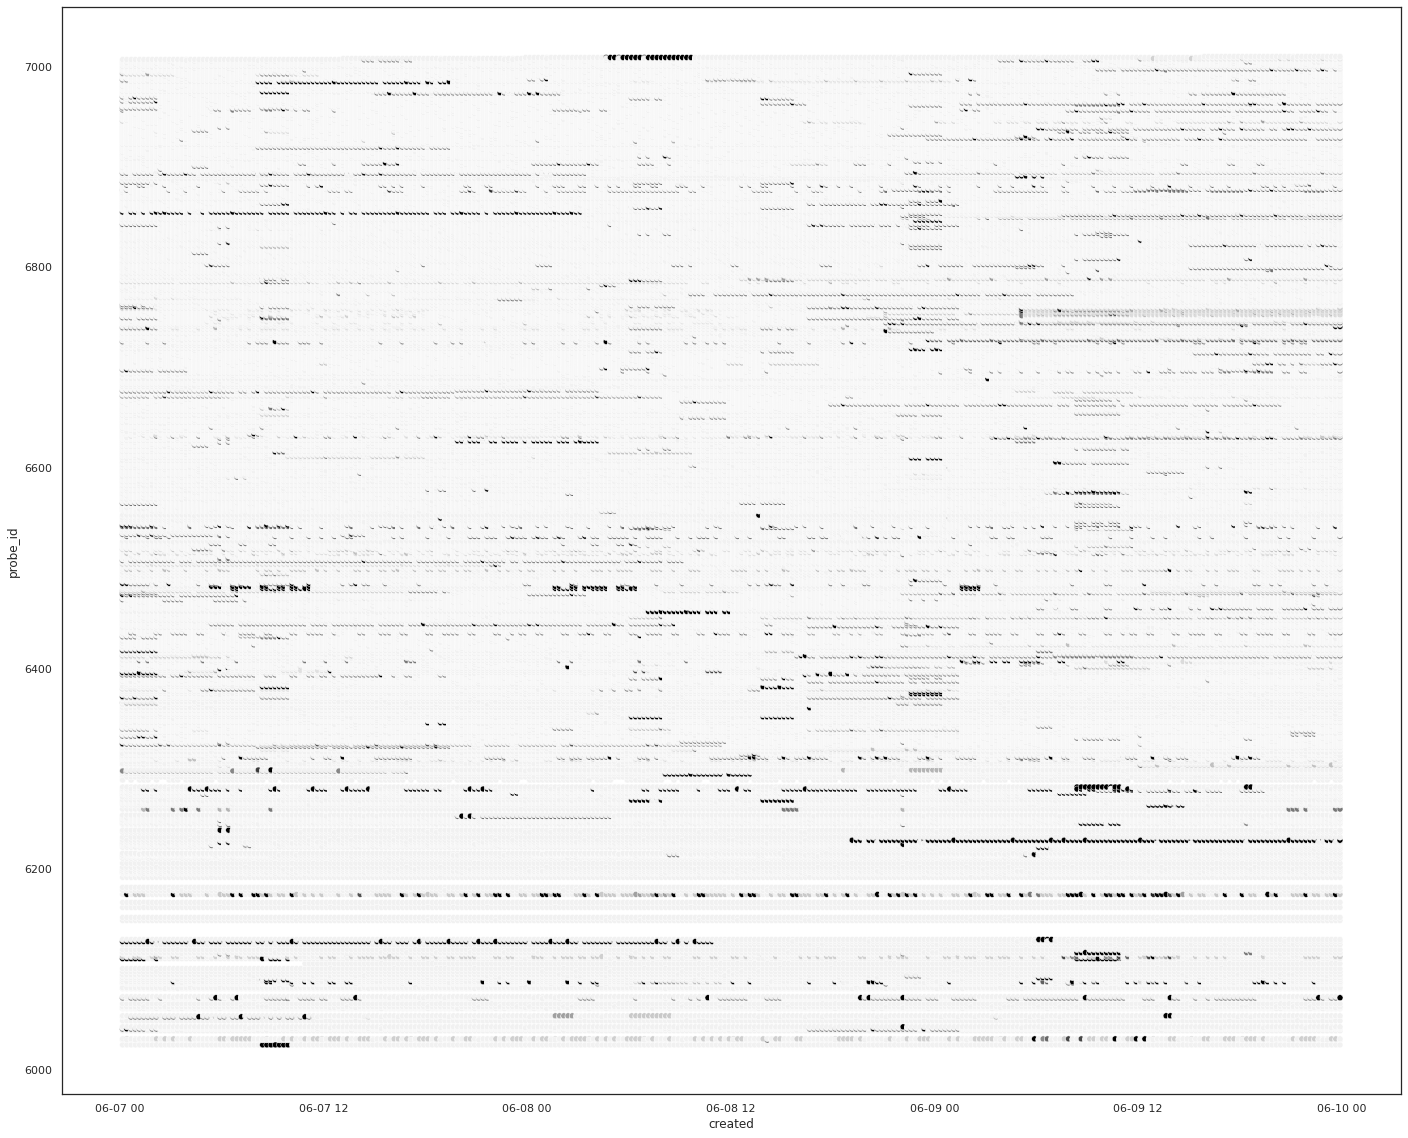

In [27]:
sns.set(rc={"figure.figsize":(24, 20)})
sns.set_style("white")
sns.scatterplot(data=df, x="created", y="probe_id", hue="normalized_score",legend=False, palette="light:black")

<AxesSubplot:xlabel='created', ylabel='country_code'>

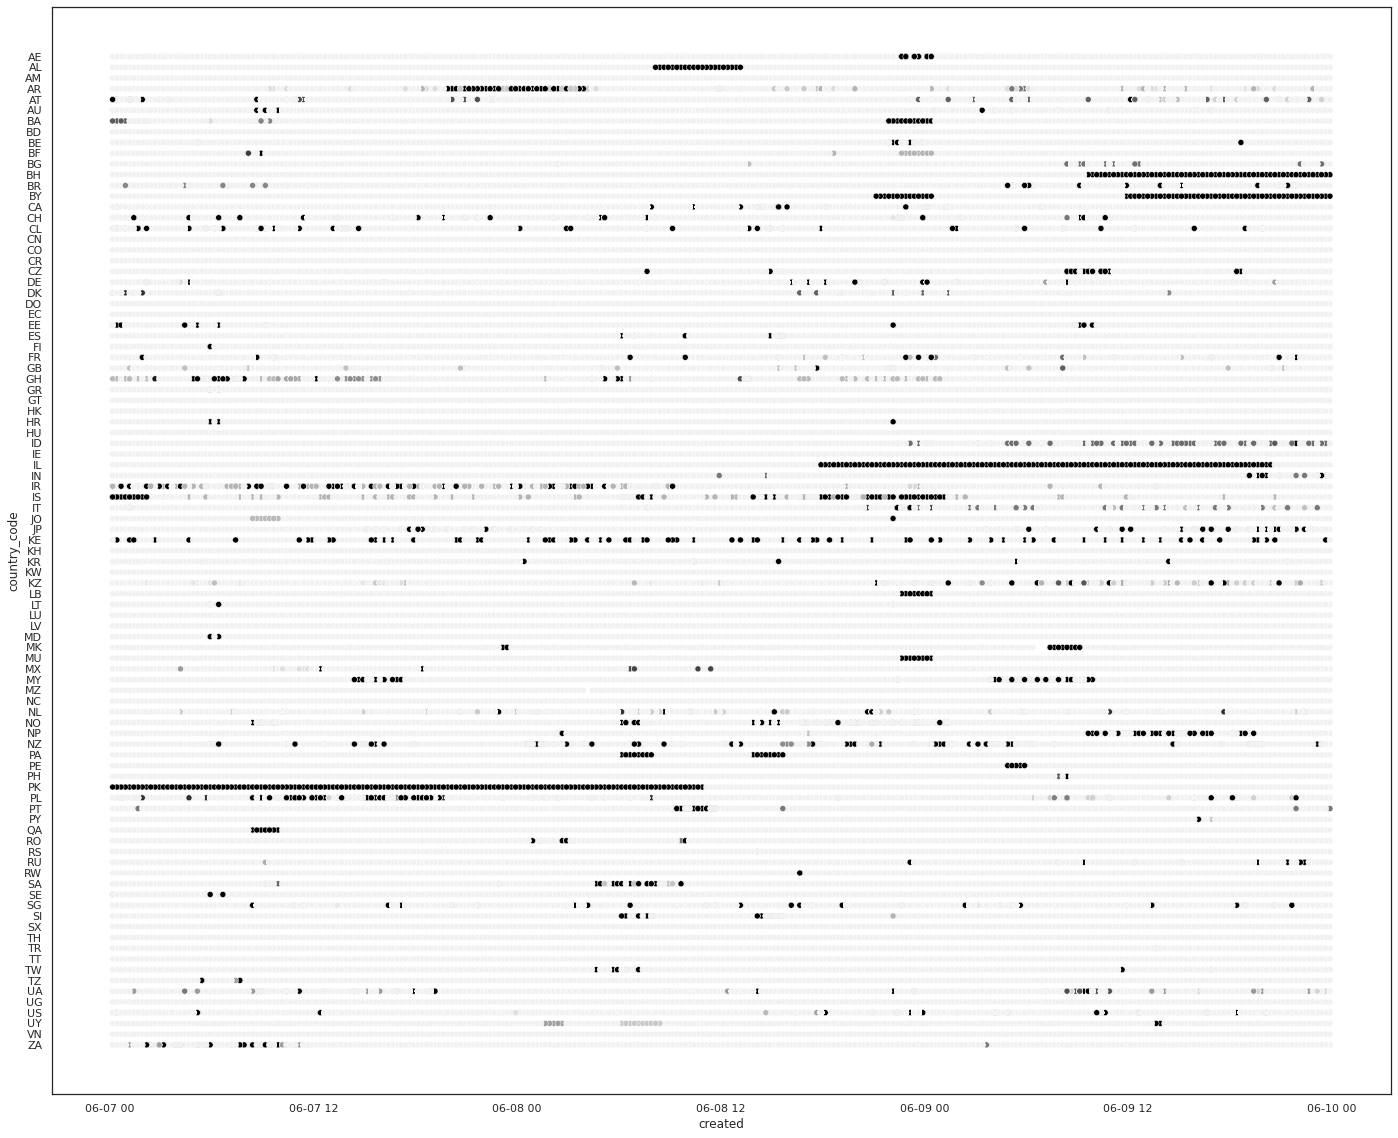

In [28]:
# group scores by country_code use the average of scores
sorted_df = df.sort_values('country_code')

sns.set(rc={"figure.figsize":(24, 20)})
sns.set_style("white")
sns.scatterplot(data=sorted_df, x="created", y="country_code", hue="normalized_score",legend=False, palette="light:black")

Probe ID: 6920
Median Total Hops: 24.0
Amount of data points: 288


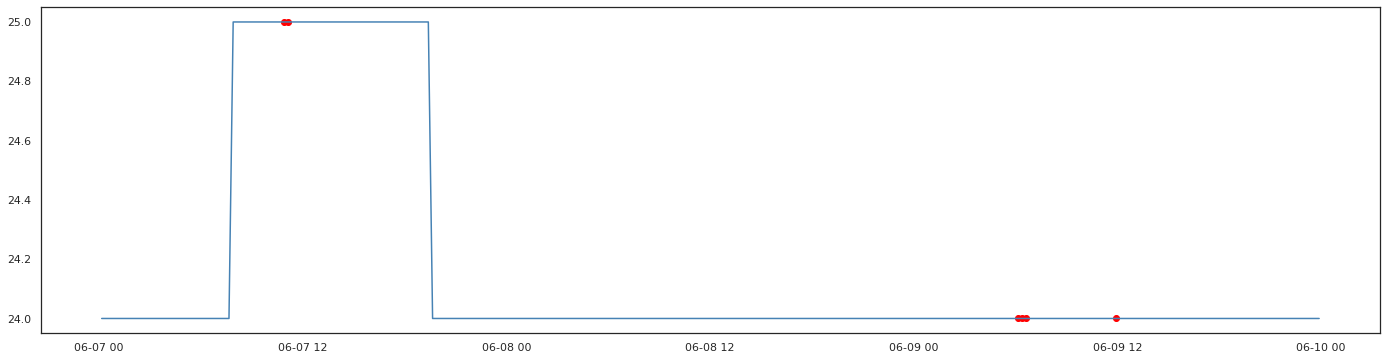

In [32]:
random_probe = df["probe_id"].sample(n=1, random_state=58).unique()[0]
# random_probe = 6229
print(f"Probe ID: {random_probe}")
single_probe1 = df[df["probe_id"] == random_probe]
single_probe1_median = single_probe1["total_hops"].median()

print(f"Median Total Hops: {single_probe1_median}")

single_probe1_datapoints = len(single_probe1)
print(f"Amount of data points: {single_probe1_datapoints}")

# Outlier detection
clf = IsolationForest(contamination=0.02)
single_probe1["outlier"] = clf.fit_predict(single_probe1[["total_hops", "last_median_rtt", "is_success"]])

# # Anomaly detection
# algo_settings = {
#       'precision':4, # how many sections to categorize values
#       'lag_window_size':2, # lagging window size
#       'future_window_size':2, # future window size,
#       'chunk_size':4 # chunk size.
#     }

# ts = single_probe1["rtt_min"].to_dict()
# detector = AnomalyDetector(ts, algorithm_name="bitmap_detector", algorithm_params=algo_settings)
# anomalies = detector.get_anomalies()

fig, ax = plt.subplots(figsize=(24,6))

# for anomaly in anomalies:
#     start = single_probe1.at[anomaly.start_timestamp, "created"]
#     end = single_probe1.at[anomaly.end_timestamp, "created"]
#     score = anomaly.anomaly_score
#     ax.axvspan(xmin=start, xmax=end, color="red")

a = single_probe1.loc[single_probe1['outlier'] == -1, ['created', 'total_hops']]
# ax.plot(single_probe1['created'], single_probe1['rtt_average_diff'], color='lightgrey')
ax.plot(single_probe1['created'], single_probe1['total_hops'], color='steelblue')
# 
ax.scatter(a["created"], a["total_hops"], color="red")
plt.show()

<AxesSubplot:xlabel='total_hops', ylabel='Count'>

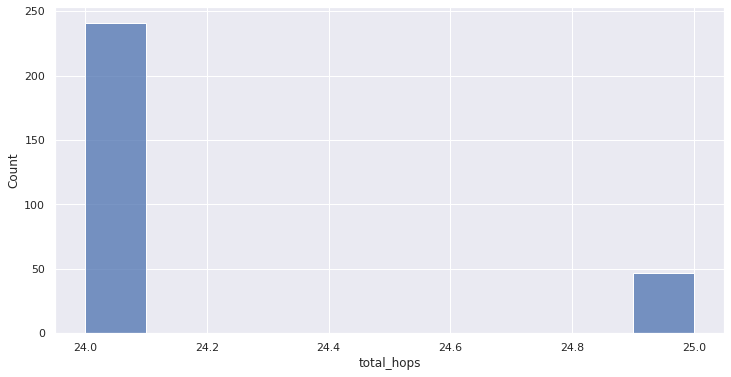

In [33]:
# check for normal distribution
sns.set(rc={"figure.figsize":(12, 6)})
sns.histplot(data=single_probe1, x="total_hops")

In [34]:
# Find outliers in total dataset
clf = IsolationForest(contamination=0.02)
df_outlier = pd.DataFrame()
for i in df["probe_id"].unique():
    single_probe = df[df["probe_id"] == i]
    
    single_probe["outlier"] = clf.fit_predict(single_probe[["total_hops", "last_median_rtt", "is_success"]])
    single_probe["outlier_score"] = clf.score_samples(single_probe[["total_hops", "last_median_rtt", "is_success"]])
    single_probe["outlier"] = single_probe["outlier"].apply(lambda x: 0 if x == 1 else 1)
    df_outlier = df_outlier.append(single_probe)

df_outlier

,index,created,probe_id,source_address,end_time,paris_id,total_hops,last_median_rtt,destination_ip_responded,last_hop_responded,is_success,last_hop_errors,median_probe_hops,not_normalized_score,normalized_score,country_code,outlier,outlier_score
0,0,2021-06-07 00:08:58+00:00,6086,80.241.3.66,2021-06-07 00:10:45+00:00,13,23,245.963,True,True,True,[],23.0,0.0,0.0,KZ,0,-0.364967
772,772,2021-06-07 00:24:01+00:00,6086,80.241.3.66,2021-06-07 00:25:52+00:00,14,23,244.963,True,True,True,[],23.0,0.0,0.0,KZ,0,-0.349248
1470,1470,2021-06-07 00:39:08+00:00,6086,80.241.3.66,2021-06-07 00:40:47+00:00,15,23,244.963,True,True,True,[],23.0,0.0,0.0,KZ,0,-0.349248
2180,2180,2021-06-07 00:54:03+00:00,6086,80.241.3.66,2021-06-07 00:55:54+00:00,0,23,244.963,True,True,True,[],23.0,0.0,0.0,KZ,0,-0.349248
2883,2883,2021-06-07 01:09:10+00:00,6086,80.241.3.66,2021-06-07 01:10:57+00:00,1,23,244.963,True,True,True,[],23.0,0.0,0.0,KZ,0,-0.349248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200963,200963,2021-06-09 22:54:05+00:00,7010,63.222.189.7,2021-06-09 22:55:35+00:00,13,20,176.146,True,True,True,[],20.0,0.0,0.0,SG,0,-0.410306
201673,201673,2021-06-09 23:09:03+00:00,7010,63.222.189.7,2021-06-09 23:10:41+00:00,14,20,176.149,True,True,True,[],20.0,0.0,0.0,SG,0,-0.394455
202381,202381,2021-06-09 23:24:12+00:00,7010,63.222.189.7,2021-06-09 23:25:46+00:00,15,20,176.136,True,True,True,[],20.0,0.0,0.0,SG,0,-0.445273
203090,203090,2021-06-09 23:39:07+00:00,7010,63.222.189.7,2021-06-09 23:40:53+00:00,0,20,176.125,True,True,True,[],20.0,0.0,0.0,SG,0,-0.509085


<AxesSubplot:xlabel='created'>

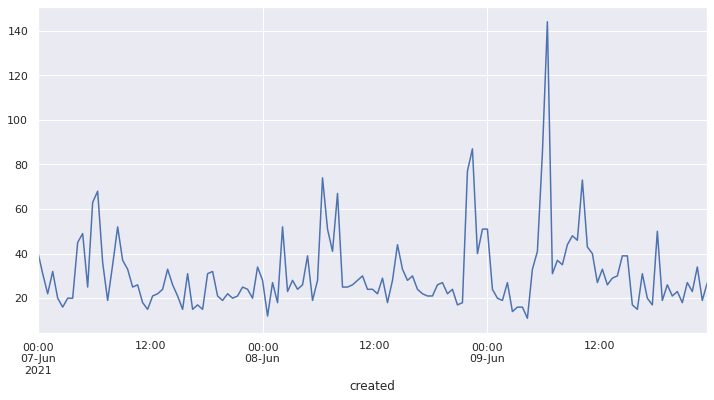

In [37]:
# Create anomaly score frame
df_outlier.groupby(pd.Grouper(key="created", freq="32T"))["outlier"].agg("sum").plot()

<AxesSubplot:xlabel='created'>

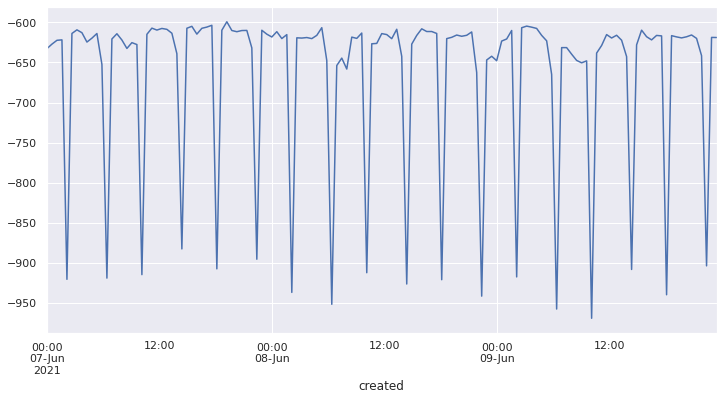

In [38]:
df_outlier.groupby(pd.Grouper(key="created", freq="32T"))["outlier_score"].agg("sum").plot()